In [1]:
import sys
sys.path.append("../")
from Linearity import Neuron
import numpy as np
import scipy.stats as ss
import matplotlib
import matplotlib.pyplot as plt
from pickle import dump
plt.style.use('neuron')

In [7]:
def simpleaxis(axes, every=False, outward=True):
    if not isinstance(axes, (list, np.ndarray)):
        axes = np.array([axes])
    for ax in np.array(axes).flatten():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if (outward):
            ax.spines['bottom'].set_position(('outward', 10))
            ax.spines['left'].set_position(('outward', 10))
        if every:
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_title('')

In [3]:
#fileList = glob.glob("/media/sahil/NCBS_Shares_BGStim/patch_data/**/c?/plots/*.pkl")
neuronList = []
with open("/media/sahil/NCBS_Shares_BGStim/patch_data/current_clamp_files.txt", 'r') as fp:
    fileList = fp.read().splitlines()
    for i,filename in enumerate(fileList):
        fileList[i] += "plots/" + filename.split('/')[-2] + ".pkl"
        try:
            print ("Reading ", fileList[i])
            neuronList.append(Neuron.load(fileList[i]))
        except:
            print ("Couldn't read", fileList[i])
print ("Read {} files.".format(len(fileList)))

Reading  /media/sahil/NCBS_Shares_BGStim/patch_data/150828/c2/plots/c2.pkl
Reading  /media/sahil/NCBS_Shares_BGStim/patch_data/150902/c1/plots/c1.pkl
Reading  /media/sahil/NCBS_Shares_BGStim/patch_data/150902/c2/plots/c2.pkl
Reading  /media/sahil/NCBS_Shares_BGStim/patch_data/150904/c1/plots/c1.pkl
Reading  /media/sahil/NCBS_Shares_BGStim/patch_data/150904/c3/plots/c3.pkl
Reading  /media/sahil/NCBS_Shares_BGStim/patch_data/160126/c3/plots/c3.pkl
Reading  /media/sahil/NCBS_Shares_BGStim/patch_data/160209/c4/plots/c4.pkl
Reading  /media/sahil/NCBS_Shares_BGStim/patch_data/160219/c5/plots/c5.pkl
Reading  /media/sahil/NCBS_Shares_BGStim/patch_data/160223/c2/plots/c2.pkl
Reading  /media/sahil/NCBS_Shares_BGStim/patch_data/160223/c3/plots/c3.pkl
Reading  /media/sahil/NCBS_Shares_BGStim/patch_data/160513/c5/plots/c5.pkl
Reading  /media/sahil/NCBS_Shares_BGStim/patch_data/160617/c5/plots/c5.pkl
Reading  /media/sahil/NCBS_Shares_BGStim/patch_data/160817/c2/plots/c2.pkl
Reading  /media/sahil/NCB

## 3 E: 4 measures of sublinearity

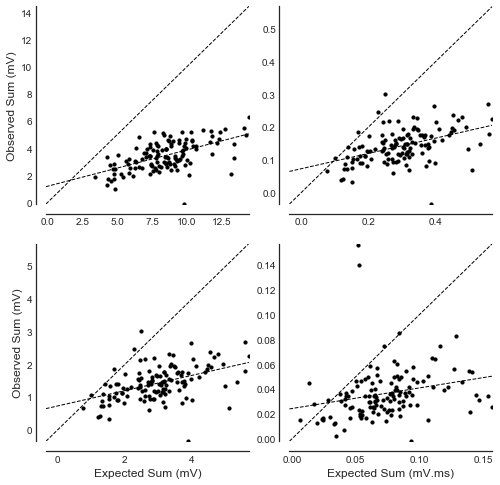

In [9]:
fig, ax = plt.subplots(2,2)
n = neuronList[11]
# fig.suptitle("Example cell: {}, {} Different measure showing sublinearity".format(n.index, n.date), fontsize=18)
features = [0,1,2,4]
for index,feature in enumerate(features):
    expected, observed = [], []
    for expType,exp in n:
        if expType == 'Control':
            sqr = 5
            expected, observed = zip(*[(exp[sqr].coordwise[coord].expected_feature[feature],exp[sqr].coordwise[coord].average_feature[feature]) for coord in exp[sqr].coordwise])
    i,j = index/2, index%2
    ax[i][j].scatter(expected, observed, label=n.features[feature], s=10)
    minLim, maxLim = min(expected + observed), max(expected + observed)
    ax[i][j].plot((minLim, maxLim), (minLim, maxLim),'--')
    slope, intercept, r2, pval,stderr = ss.linregress(expected, observed)
    expArray = np.linspace(minLim, maxLim,100)
    ax[i][j].plot(expArray, slope*expArray + intercept,'--', label="Slope = {:.2f}, $r^2={:.2f}$".format(slope, r2))
    ax[i][j].set_xlim(minLim, maxLim)
    ax[i][j].set_ylim(minLim, maxLim)
# ax[0][0].set_xlabel("Expected Sum (mV)")
ax[0][0].set_ylabel("Observed Sum (mV)")
ax[1][0].set_xlabel("Expected Sum (mV)")
ax[1][0].set_ylabel("Observed Sum (mV)")

# ax[0][1].set_xlabel("Expected Sum (mV.ms)")
# ax[0][1].set_ylabel("Observed Sum (mV.ms)")
ax[1][1].set_xlabel("Expected Sum (mV.ms)")
# ax[1][1].set_ylabel("Observed Sum (mV.ms)")

#     ax[i][j].legend(loc='best')
# for axis in ax.flatten():
#     axis.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#     axis.yaxis.major.formatter._useMathText = True
simpleaxis(ax)
fig.set_figheight(8)
fig.set_figwidth(8)
dump(fig,file('figures/fig3/3e.pkl','wb'))
plt.show()

## 3 F: Ratios of O/E mostly sublinear

In [78]:
def figureE(feature = 0):
    ''' Plotting to show sublinearity of CA3 inputs at CA1. '''
    ratio = []
    numNeurons = 0
    numBins = 300
    for neuron in neuronList:
        for expType, exp in neuron:
            if expType == "Control":            
                numNeurons+=1
                for numSq in exp:
                    if numSq > 1:
                        #if 5 in neuron.experiment[experiment]: # If one vs five required
                        coords = exp[numSq].coordwise
                        for coord in coords:
                            try:
                                if feature in coords[coord].average_feature and coords[coord].expected_feature:
                                    if not np.isnan(coords[coord].average_feature[feature]/coords[coord].expected_feature[feature]) and not np.isinf(coords[coord].average_feature[feature]/coords[coord].expected_feature[feature]):
                                        ratio.append(coords[coord].average_feature[feature]/coords[coord].expected_feature[feature])
                            except:
                                print ("Couldn't append to ratio, perhaps feature not found")
    ratio = np.array(ratio)
    gt_one = ratio[np.where(ratio>1)]
    frac_gt_one = round((float(len(gt_one))/len(ratio))*1e2,2)
    #print [x for x in ratio]
    fig, ax = plt.subplots()
    fig.set_figheight(2)
    fig.set_figwidth(2)
    n, bins, patches = ax.hist(ratio, bins=numBins, color='gray')
    
    for i in range(len(patches)):
        if bins[i]>1:
            patches[i].set_facecolor('orange')
    
    ax.set_title("Sublinearity of input summation")
#     ax.axvline(1.0, linestyle='dashed', linewidth=2, color='0.5')
    ax.set_xlabel("O/E")
    ax.set_ylabel("# PSPs")
    ax.set_xlim(0,2.5)
    simpleaxis(ax,outward=False)
    dump(fig,file('figures/fig3/3f.pkl','wb'))
#     ax.annotate("{} %".format(frac_gt_one), xy=(1, 800), xytext=(1.5, 800), textcoords='data', arrowprops=dict(connectionstyle="arc3", arrowstyle = "<-"))
    plt.show()
    print ("Legend text: Number of cells: {}, number of points: {}, fraction of points greater than one: {}".format(numNeurons, len(ratio), frac_gt_one ))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


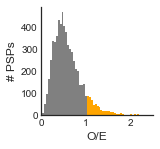

Legend text: Number of cells: 49, number of points: 6407, fraction of points greater than one: 10.75


In [79]:
figureE()

## 3 G: Regression slopes differ between cells

In [76]:
def figureF(feature = 0):
    ''' Plotting to show sublinearity of CA3 inputs at CA1. '''
    numBins = 20
    numSq = 5
    feature = 0
    slopes = []
    index = []
    for neuron in neuronList:
        for experiment in neuron.experiment:
            if experiment == "Control":            
                    try:
                        slope = neuron.experiment[experiment][numSq].regression_coefficients[feature]['slope']
                        if not np.isnan(slope):
                            index.append(neuron.date + '_' + neuron.index)
                            slopes.append(neuron.experiment[experiment][numSq].regression_coefficients[feature]['slope'])
                    except:
                        print ("Doesn't have {} square input".format(numSq))
    print (zip(index, slopes))
    fig, ax = plt.subplots()
    fig.set_figheight(3)
    fig.set_figwidth(3)
    n, bins, patches = ax.hist(slopes,bins=numBins, color='gray')
    for i in range(len(patches)):
        if bins[i]>1:
            patches[i].set_facecolor('orange')
            
    ax.set_title("Variability of slopes between cells")
    ax.axvline(1.0, linestyle='dashed', linewidth=2)
    ax.set_xlabel("Slopes")
    ax.set_ylabel("Number of cells")
    ax.set_xlim(xmin=0., xmax=1.5)
    simpleaxis(ax)
    dump(fig,file('figures/fig3/3g.pkl','wb'))
    plt.show()

Doesn't have 5 square input
Doesn't have 5 square input
Doesn't have 5 square input
Doesn't have 5 square input
Doesn't have 5 square input
Doesn't have 5 square input
Doesn't have 5 square input
[('150828_c2', 0.44108061782391944), ('150902_c1', 0.82916980424324238), ('150902_c2', 0.34272897404315489), ('150904_c1', 0.50485663609418274), ('160209_c4', 0.10510301937759157), ('160219_c5', 0.46763050227866282), ('160223_c2', 0.63928281431893319), ('160617_c5', 0.26736486153663075), ('160830_c1', 0.04706707834265289), ('160920_c1', 0.3192481698191002), ('160927_c3', -0.02978580380142368), ('160927_c1', 0.38578678336863415), ('160928_c3', 0.16059020256091919), ('161013_c1', 0.26611843310212735), ('161026_c1', 0.48114459901706247), ('161027_c3', 0.4216898754083781), ('161109_c3', 0.42322085514448848), ('161110_c1', 0.52113916773113833), ('161116_c2', 0.53987391679584074), ('161117_c1', 0.028628735186219834), ('161228_c1', 0.4218479793905513), ('170104_c4', 0.59554530975909226), ('170208_c3'

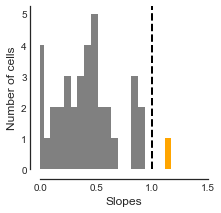

In [77]:
figureF()